In [55]:
# !pip install numpy
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn
# !pip install matplotlib
# !pip install wordcloud

In [145]:
# import libraries
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline

In [57]:
# download packages necessary for nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/roozendaal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Collection

In [58]:
# Load in dataset
data = pd.read_csv('spam.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preparation

In [59]:
example = 'This is an example sentence, with some punctuation,.!     characters &* and smileys :)'

In [60]:
# split sentence on whitespace, keeping all punctuation as part of a word
example.split()

['This',
 'is',
 'an',
 'example',
 'sentence,',
 'with',
 'some',
 'punctuation,.!',
 'characters',
 '&*',
 'and',
 'smileys',
 ':)']

In [61]:
# split on words and punctuation with word tokenizer from the nltk package
word_tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 ',',
 'with',
 'some',
 'punctuation',
 ',',
 '.',
 '!',
 'characters',
 '&',
 '*',
 'and',
 'smileys',
 ':',
 ')']

In [62]:
# Lowercase all words
data['Message'] = data['Message'].str.lower()

In [63]:
# Tokenize all sentences
data['tokens'] = data['Message'].apply(word_tokenize)

In [64]:
def remove_tokens(tokens, tokens_to_remove):
    return [word for word in tokens if word not in tokens_to_remove]

In [65]:
# Remove stopwords
stopwords = ['the', 'a', 'an', 'is']
data['cleaned_tokens'] = data['tokens'].apply(remove_tokens, args=(stopwords,))

In [66]:
# Remove punctuation
punctuation = [',', '.', ':']
data['cleaned_tokens'] = data['tokens'].apply(remove_tokens, args=(punctuation,))

In [67]:
# Stemming
# There are 2 different stemmers, you can play around to see the difference!
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [68]:
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()

In [69]:
def stem_tokens(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

In [70]:
examples = ['connect', 'connection', 'connections', 'connected', 'connecting', 'connectiion']

print('porter stemmer: ', stem_tokens(examples, porter_stemmer))
print('lancaster stemmer: ', stem_tokens(examples, lancaster_stemmer))

porter stemmer:  ['connect', 'connect', 'connect', 'connect', 'connect', 'connectiion']
lancaster stemmer:  ['connect', 'connect', 'connect', 'connect', 'connect', 'connecty']


In [71]:
data['stemmed_tokens'] = data['cleaned_tokens'].apply(stem_tokens, args=(porter_stemmer,))

In [72]:
data.head(2)

,Category,Message,tokens,cleaned_tokens,stemmed_tokens
0,ham,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, until, jurong, point, crazi, .., avail, o..."
1,ham,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joke, wif, u, oni, ...]"


# Data Exploration

In [73]:
# Count the number of ham / spam in the Category column
data.groupby('Category').count()

,Message,tokens,cleaned_tokens,stemmed_tokens
Category,,,,
ham,4825,4825,4825,4825
spam,747,747,747,747


<AxesSubplot:>

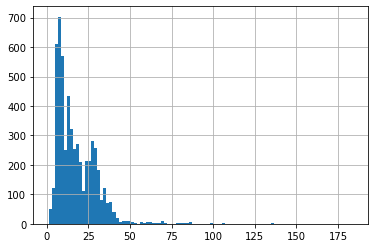

In [134]:
# Distribution of the nr of words per sentence
data['stemmed_tokens'].str.len().hist(bins=100)

In [74]:
# Make separate variables for spam and ham categories
ham = data[data['Category'] == 'ham']
spam = data[data['Category'] == 'spam']

In [75]:
# Store all tokens for category ham in one list, "explode" is a very handy buildin function for that
ham_tokens = ham.explode('stemmed_tokens')['stemmed_tokens']
# Count the frequencies per word
ham_tokens.value_counts()[:10]

i      2880
you    1939
to     1562
?      1375
...    1139
the    1131
a      1064
u       994
it      924
and     856
Name: stemmed_tokens, dtype: int64

In [76]:
# Store all tokens for category spam in one list
spam_tokens = spam.explode('stemmed_tokens')['stemmed_tokens']
# Count the frequencies per word
spam_tokens.value_counts()[:10]

to      687
!       546
a       377
call    362
you     297
your    278
free    219
the     203
for     203
now     199
Name: stemmed_tokens, dtype: int64

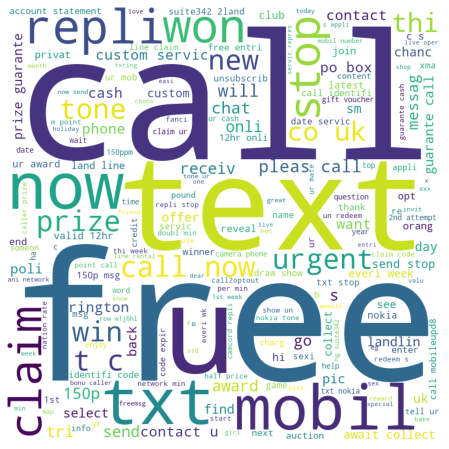

In [77]:
# Show word cloud for spam tokens
# TODO: try with ham tokens
one_big_string_of_tokens = ' '.join(spam_tokens)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(one_big_string_of_tokens)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off");

In [78]:
# Make a vocabulary for typical spam and ham keywords
spam_keywords = ['claim', 'win', 'repli', 'urgent', 'call', 'free', 'prize', 'now', 'txt', '$', 'click', 'here',
                'onlin', 'select']
ham_keywords = ['go', 'love', 'come', 'will', 'thanks', 'hope', 'time', 'friend', 'tonight', 'tomorrow', 
                'ok', 'meet', 'darl']
ham_spam_vocabulary = sorted(spam_keywords + ham_keywords)

In [79]:
# The Data exploration / preparation phase usually consists of a few iterations
# TODO: add more punctuation
# TODO: add more stopwords
# TODO: add more spam / ham keywords

# Word vectors

In [80]:
def transform_text_to_vector(tokens, vocabulary):
    # count frequency of the vocabulary words per message and store in a sorted (alphabetical) list = vector
    word_frequencies = []
    for vocabulary_word in vocabulary:
        word_frequencies.append(tokens.count(vocabulary_word))
    return np.array(word_frequencies)

In [81]:
# Example message
data['Message'].iloc[8]

'winner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.'

In [135]:
# vocabulary
print(ham_spam_vocabulary)

['$', 'call', 'claim', 'click', 'come', 'darl', 'free', 'friend', 'go', 'here', 'hope', 'love', 'meet', 'now', 'ok', 'onlin', 'prize', 'repli', 'select', 'thanks', 'time', 'tomorrow', 'tonight', 'txt', 'urgent', 'will', 'win', '£']


In [136]:
# The vector of the message containing the counts for typical ham/spam keywords
vectors = transform_text_to_vector(data['stemmed_tokens'].iloc[8], ham_spam_vocabulary)
vectors

array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [137]:
# Make vectors out of all messages
vectors = data['stemmed_tokens'].apply(transform_text_to_vector, args=(ham_spam_vocabulary,))

# Data modelling

In [138]:
# Transform labels to numbers
mapping = {'ham': 0,
          "spam": 1}

data['labels'] = data['Category'].map(mapping)

In [139]:
X = list(vectors)
y = data['labels']

In [140]:
# Split the data in train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [141]:
print(len(X_train), len(X_val), len(X_test))

3342 1115 1115


In [147]:
# make sure that the all sets contain enough spam and ham labels
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(0    2865
 1     477
 Name: labels, dtype: int64,
 0    992
 1    123
 Name: labels, dtype: int64,
 0    968
 1    147
 Name: labels, dtype: int64)

In [ ]:
# TOTHINK: What happens if the train data does not contain any or litte spam labels? 
# You could try it out by only including a few spam labels in the trainset! 
# And play around with the nr of spam lables in the val set

In [113]:
# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

LogisticRegression()

In [114]:
# Predict the validation set!
predictions = clf.predict(X_val)

# Evaluation 
dummy data

In [45]:
# For each predictions was it a correct one? 6/7 are correct
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
accuracy_score(y_true, y_pred)

0.8571428571428571

In [46]:
# Precision: how many retrieved items are relevant?

# Out of all "positive" predicted items? How many are truly positive?
# The 3 positive predictions are truly positive
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
precision_score(y_true, y_pred)

1.0

In [47]:
# Recall: How many relevant items are retrieved?

# Out of all items that were truly "positive"? How many did "positive"  did we predict? 
# 3 out of 4 predictions are positive
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
recall_score(y_true, y_pred)

0.75

In [48]:
# Weighted average of precision and recall
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
f1_score(y_true, y_pred)

0.8571428571428571

# Evaluation 
Ham / Spam data

In [148]:
y_true = y_val.copy()
y_pred = clf.predict(X_val)

In [149]:
print('accuracy: ', accuracy_score(y_true, y_pred))
print('precision: ', precision_score(y_true, y_pred))
print('recall: ', recall_score(y_true, y_pred))
print('f1 score: ', f1_score(y_true, y_pred))

accuracy:  0.9443946188340807
precision:  0.8674698795180723
recall:  0.5853658536585366
f1 score:  0.6990291262135921


In [151]:
confusion_matrix(y_true, y_pred)

array([[981,  11],
       [ 51,  72]])

# Error analysis

In [152]:
# make a new dataframe with categories, true labels and predicted labels
predictions_df = pd.DataFrame(data['Category'].loc[y_true.index])
predictions_df['y_true'] = y_true
predictions_df['y_pred'] = y_pred
predictions_df['message'] = data.loc[y_true.index, 'Message']

In [153]:
# Explore the wrong predictions
predictions_df[predictions_df['y_true'] != predictions_df['y_pred']]

,Category,y_true,y_pred,message
3738,ham,0,1,plz note: if anyone calling from a mobile co. ...
5041,spam,1,0,natalie (20/f) is inviting you to be her frien...
3768,ham,0,1,"sir goodmorning, once free call me."
3568,spam,1,0,collect your valentine's weekend to paris inc ...
3720,spam,1,0,"thanks for your ringtone order, reference numb..."
...,...,...,...,...
3303,ham,0,1,stop calling everyone saying i might have canc...
3222,spam,1,0,"thanks for your ringtone order, reference numb..."
5365,spam,1,0,camera - you are awarded a sipix digital camer...
474,spam,1,0,want 2 get laid tonight? want real dogging loc...


In [ ]:
# I think we can push the scores way higher! 
# You can play around and do many many iterations with the validation set

# If you're satisfied with the results, you can use the model for "unseen" messages -> the test set!

# THE SHORT WAY

In [154]:
# Load data
data = pd.read_csv('spam.csv')

# Initialize the Bag of Words model
# This model does lowercasing, tokenization, stemming and optionally removal of stopwords! 
cv = CountVectorizer(stop_words='english')

# vectorize the sentences
X = cv.fit_transform(data['Message']).toarray()
y = data['Category'].map(mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate!
print('accuracy: ', accuracy_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.9829596412556054
precision:  0.9923076923076923
recall:  0.8775510204081632
f1 score:  0.9314079422382673


In [155]:
confusion_matrix(y_test, y_pred)

array([[967,   1],
       [ 18, 129]])

In [157]:
predictions_df = pd.DataFrame(data['Category'].loc[y_test.index])
predictions_df['y_true'] = y_test
predictions_df['y_pred'] = y_pred
predictions_df['message'] = data.loc[y_test.index, 'Message']

In [158]:
predictions_df[predictions_df['y_true'] != predictions_df['y_pred']]

,Category,y_true,y_pred,message
1777,spam,1,0,Call FREEPHONE 0800 542 0578 now!
1217,spam,1,0,You have 1 new voicemail. Please call 08719181...
763,spam,1,0,Urgent Ur £500 guaranteed award is still uncla...
3780,spam,1,0,"Claim a 200 shopping spree, just call 08717895..."
3132,spam,1,0,LookAtMe!: Thanks for your purchase of a video...
2295,spam,1,0,You have 1 new message. Please call 08718738034.
5110,spam,1,0,You have 1 new message. Please call 08715205273
1045,spam,1,0,We know someone who you know that fancies you....
5,spam,1,0,FreeMsg Hey there darling it's been 3 week's n...
4073,spam,1,0,Loans for any purpose even if you have Bad Cre...
